In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
n_core = 3.5    # Refractive index of core
n_clad = 1.0    # Refractive index of cladding
d = 8e-6        # Width of the MMI device (in meters)
wavelength = 1.55e-6  # Wavelength (in meters)
FWHM = 1e-6  # Full width at half maximum in meters
num_modes = 10

In [4]:
w_eq = d + (wavelength / np.pi) * (n_core**2 - n_clad**2)**(-0.5)
L_pi = (4 * n_core * d**2) / (3 * wavelength)
k0 = 2 * np.pi / wavelength
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))

print(f"W_eq = {w_eq * 1e6} µm")
print(f"L_π = {L_pi * 1e6} µm")

W_eq = 8.147097592306217 µm
L_π = 192.68817204301078 µm


In [5]:
def calculate_L(L_pi, number_of_splits, p=1):
    L =(p / number_of_splits) * (3 * L_pi / 4)
    return L

In [6]:
L = calculate_L(L_pi, 2, p=1)
print(f"The minimal length of L to split power 50:50 is {L* 1e6} µm")

The minimal length of L to split power 50:50 is 72.25806451612904 µm


In [7]:
x = np.linspace(-w_eq / 2, w_eq / 2, 1000)  # Lateral positions
gaussian_profile = np.exp(-x**2 / (2 * sigma**2))

In [8]:
def calculate_beta(i):
    beta = k0 * n_core - ((i + 1) ** 2 * np.pi * wavelength) / (4 * n_core * w_eq**2)
    return beta

def calculate_k_x(i):
    k_x = (i + 1) * np.pi / w_eq
    return k_x

def calculate_eigenmode(k_x, x):
    eigenmode = np.sin(k_x * (x + w_eq/2))
    return eigenmode

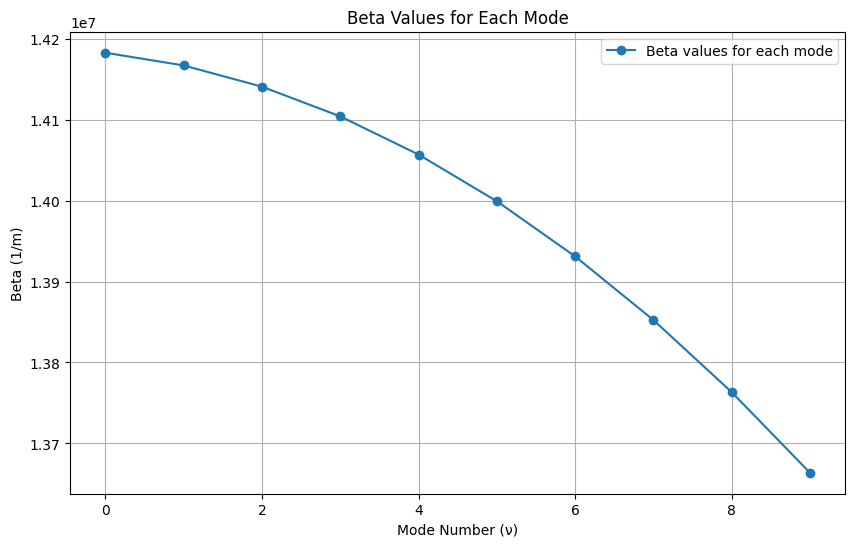

In [9]:
# Calculate eigenfunctions for each mode
beta_values = [calculate_beta(i) for i in range(num_modes)]
k_x_values = [calculate_k_x(i) for i in range(num_modes)]
eigen_modes = [calculate_eigenmode(k_x, x) for k_x in k_x_values]

# Plot beta values and eigenfunctions
plt.figure(figsize=(10, 6))
plt.plot(range(num_modes), beta_values, 'o-', label="Beta values for each mode")
plt.xlabel("Mode Number (ν)")
plt.ylabel("Beta (1/m)")
plt.title("Beta Values for Each Mode")
plt.grid()
plt.legend()
plt.show()

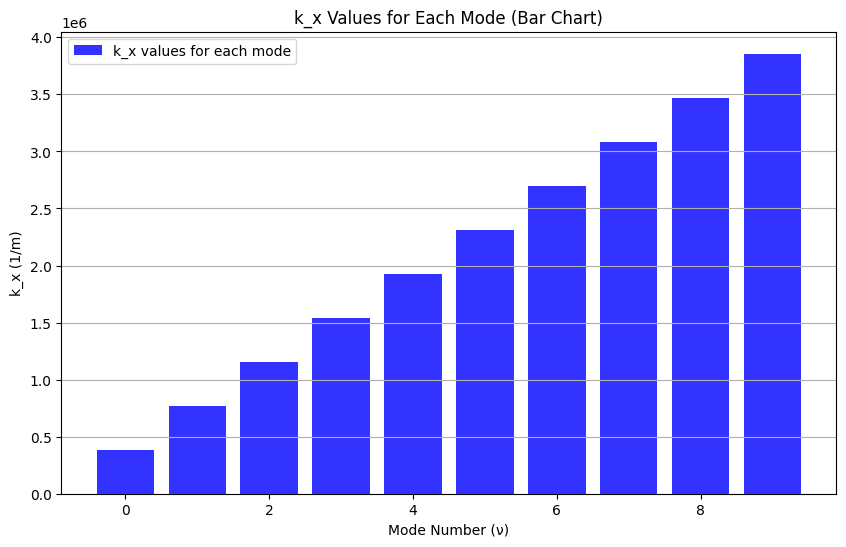

In [10]:
# Plot k_x values as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(num_modes), k_x_values, color='blue', alpha=0.8, label="k_x values for each mode")
plt.xlabel("Mode Number (ν)")
plt.ylabel("k_x (1/m)")
plt.title("k_x Values for Each Mode (Bar Chart)")
plt.grid(axis='y')
plt.legend()
plt.show()

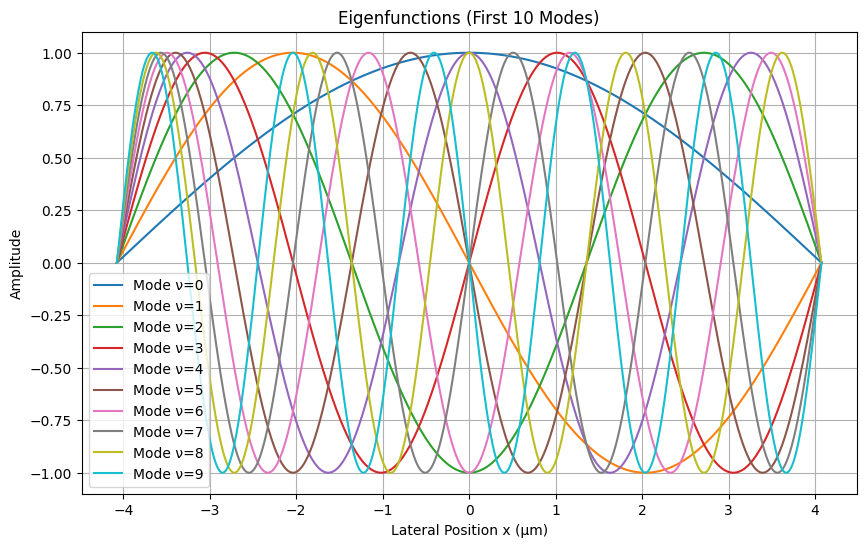

In [11]:
# Plot eigenfunctions
plt.figure(figsize=(10, 6))
for v, psi in enumerate(eigen_modes):  # Plot first 5 modes
    plt.plot(x * 1e6, psi, label=f"Mode ν={v}")
plt.xlabel("Lateral Position x (µm)")
plt.ylabel("Amplitude")
plt.title("Eigenfunctions (First 10 Modes)")
plt.legend()
plt.grid()
plt.show()

In [12]:
def calculate_coefficients(input_function, eigenfunctions, x):
    coefficients = []
    for eigenfunction in eigenfunctions:
        # Numerator: Integral of input_function * eigenfunction
        numerator = simpson(input_function * np.conj(eigenfunction))

        # Denominator: Integral of eigenfunction^2
        denominator = simpson(np.abs(eigenfunction)**2)

        # Coefficient for this mode
        coefficient = numerator / denominator
        coefficients.append(coefficient)

    return coefficients

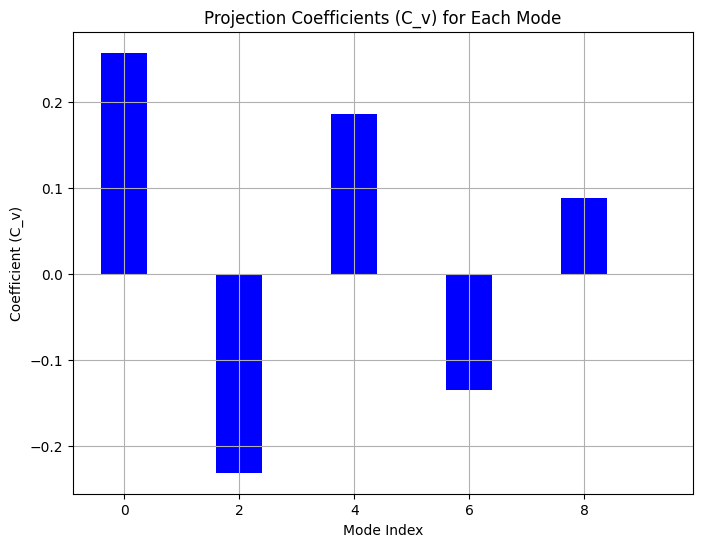

In [13]:
coefficients = calculate_coefficients(gaussian_profile, eigen_modes, x)

plt.figure(figsize=(8, 6))
plt.bar(range(num_modes), coefficients, color='blue')
plt.xlabel("Mode Index")
plt.ylabel("Coefficient (C_v)")
plt.title("Projection Coefficients (C_v) for Each Mode")
plt.grid()
plt.show()

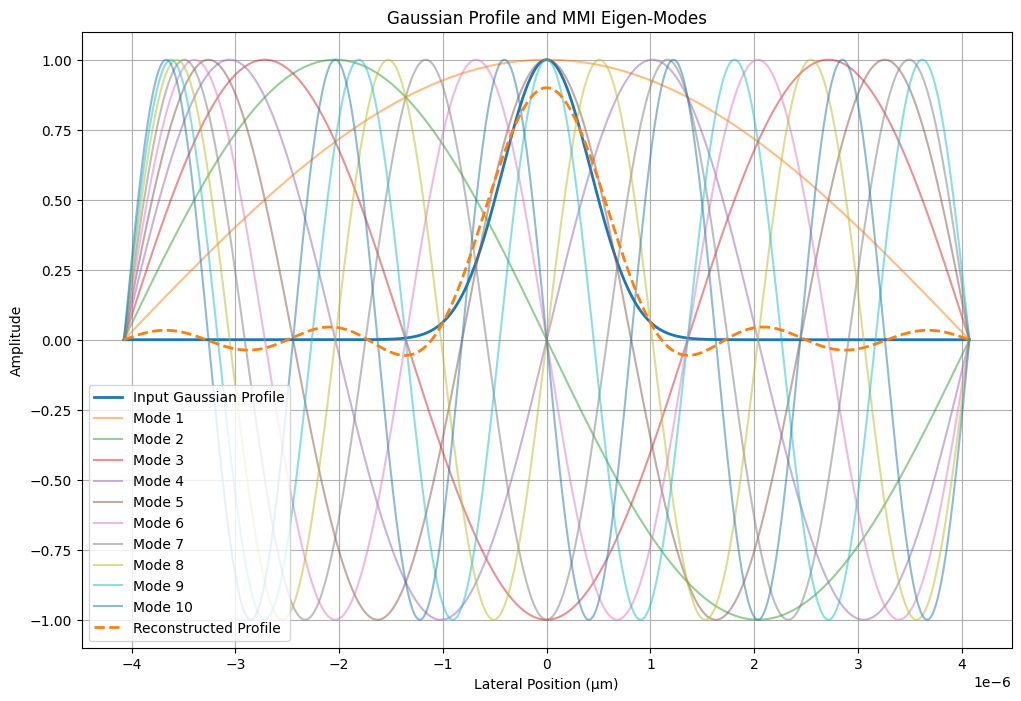

In [14]:
reconstructed_profile = sum(c * mode for c, mode in zip(coefficients, eigen_modes))

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(x, gaussian_profile, label="Input Gaussian Profile", linewidth=2)
for n, mode in enumerate(eigen_modes, 1):
    plt.plot(x, mode, label=f"Mode {n}", alpha=0.5)
plt.plot(x, reconstructed_profile, label="Reconstructed Profile", linestyle='--', linewidth=2)
plt.xlabel("Lateral Position (µm)")
plt.ylabel("Amplitude")
plt.title("Gaussian Profile and MMI Eigen-Modes")
plt.legend()
plt.grid()
plt.show()

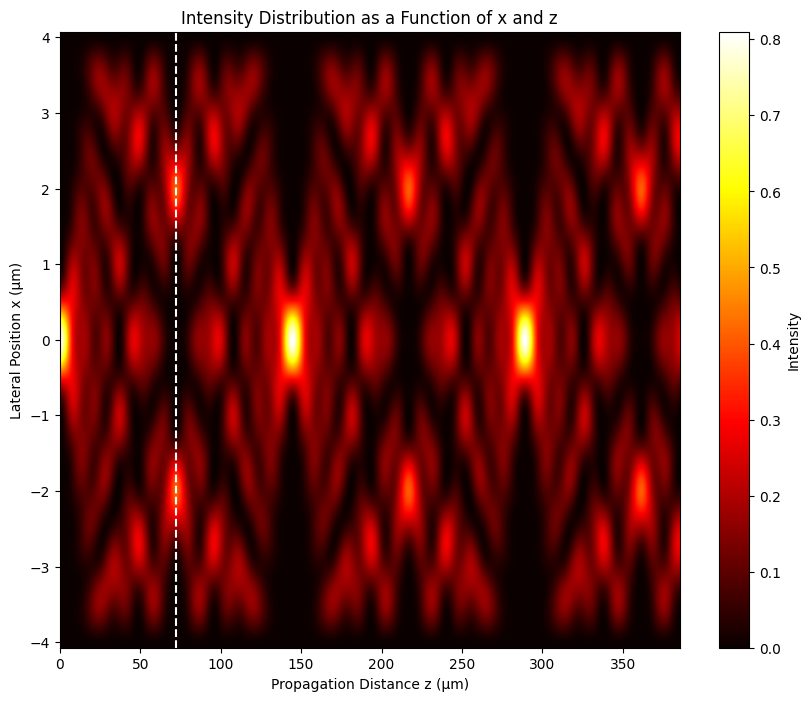

In [15]:
z = np.linspace(0, 2 * L_pi, 5000)  # Propagation distance
intensity = np.zeros((len(x), len(z)))

# Plot the intensity as a function of x and z
plt.figure(figsize=(10, 8))

plt.axvline(L * 1e6, color='white', linestyle='--')

# Calculate the intensity as a function of x and z
for zi, z_val in enumerate(z):
    field_at_z = np.zeros_like(x, dtype=complex)
    for v, mode in enumerate(eigen_modes):
        phase = np.exp(-1j * (v * (v + 2) * np.pi / (3 * L_pi)) * z_val)
        field_at_z += coefficients[v] * mode * phase
    intensity[:, zi] = np.abs(field_at_z)**2  # Intensity is the magnitude squared

plt.imshow(intensity, extent=[z[0] * 1e6, z[-1] * 1e6, x[0] * 1e6, x[-1] * 1e6],
           aspect='auto', origin='lower', cmap='hot')

plt.colorbar(label='Intensity')
plt.xlabel("Propagation Distance z (µm)")
plt.ylabel("Lateral Position x (µm)")
plt.title("Intensity Distribution as a Function of x and z")
plt.show()

In [16]:
field_at_L = np.zeros_like(x, dtype=complex)

for v, mode in enumerate(eigen_modes):
        phase = np.exp(-1j * (v * (v + 2) * np.pi / (3 * L_pi)) * L)
        field_at_L += coefficients[v] * mode * phase
    
field_at_L = np.abs(field_at_L)**2

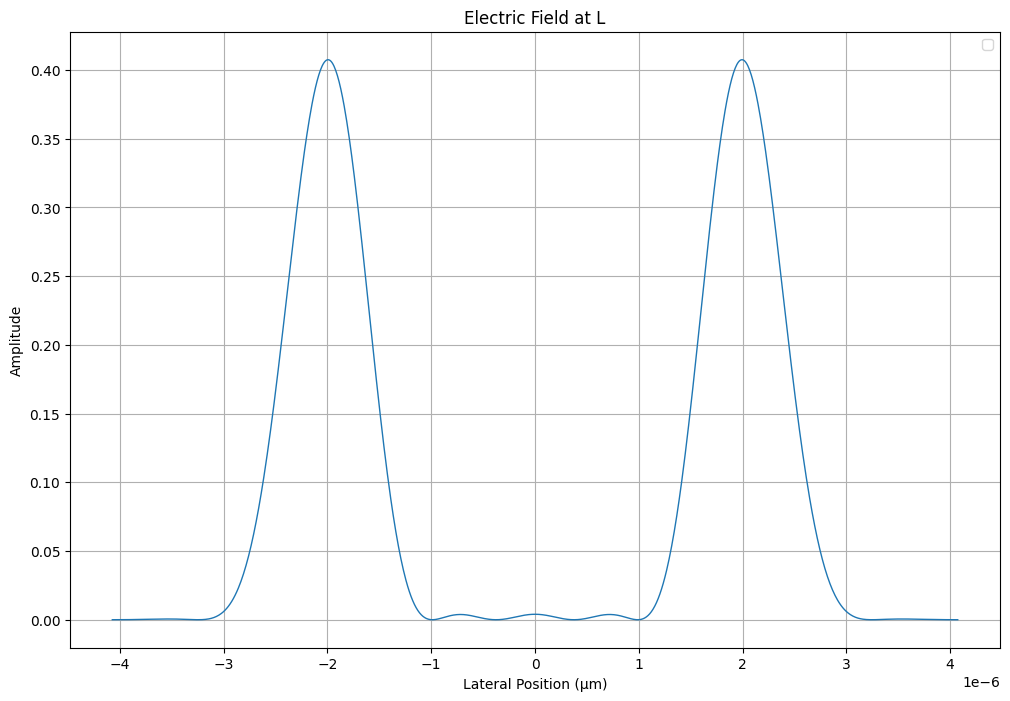

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(x,field_at_L , linewidth=1)
plt.xlabel("Lateral Position (µm)")
plt.ylabel("Amplitude")
plt.title("Electric Field at L")
plt.legend()
plt.grid()
plt.show()